# DFT + GWBSE Energy Calculation Using CH4

## Introduction

This tutorial explains how to perform calculation to predict electronic excitation using the **GWBSE** method. See [the GW Compendium: A Practical Guide to Theoretical Photoemission Spectroscopy](https://doi.org/10.3389/fchem.2019.00377), for an excellent introduction to the method.

## Requirements
* You will need to install **VOTCA** using the instructions described [here](https://github.com/votca/votca/blob/master/share/sphinx/INSTALL.rst)
* Once the installation is completed you need to activate the VOTCA enviroment by running the `VOTCARC.bash` script that has been installed at the bin subfolder for the path that you have provided for the installation step above

## Interacting with the XTP command line interface
To run a DFT-GWBSE calculation we will use the [xtp_tools](https://www.votca.org/xtp/xtp_tools_overview.html) calculator. Run the following command to view the help message of `xtp_tools`:

In [1]:
!xtp_tools --help

========   VOTCA (http://www.votca.org)   ========

please read and cite: https://doi.org/10.21105/joss.06864
and submit bugs to https://github.com/votca/votca/issues

xtp_tools, version 2024.2-dev gitid: 22618c7 (compiled Mar 28 2025, 05:58:09)

Runs excitation/charge transport tools



Allowed options:
  -h [ --help ]                 display this help and exit
  --verbose                     be loud and noisy
  --verbose1                    be very loud and noisy
  -v [ --verbose2 ]             be extremly loud and noisy
  -o [ --options ] arg          Tool user options.
  -t [ --nthreads ] arg (=1)    number of threads to create
  -e [ --execute ] arg        Name of Tool to run
  -l [ --list ]               Lists all available Tools
  -d [ --description ] arg    Short description of a Tools
  -c [ --cmdoptions ] arg     Modify options via command line by e.g. '-c 
                              xmltag.subtag=value'. Use whitespace to separate 
                              multiple o

### Note
> * In Jupyter the `!` symbol means: *run the following command as a standard unix command*
> * In Jupyter the command `%env` set an environmental variable

## Running a calculation with the default options
To run a DFT-GWBSE calculation we just need to provide the path to the file in XYZ with the molecular coordinates. Check the [dftgwbse defaults](https://www.votca.org/xtp/dftgwbse.html) for further information.

In [2]:
!xtp_tools -c job_name=methane -t 2 -e dftgwbse > dftgwbse.log

The previous command will run the DFT-GWBSE calculation using the aforementioned defaults and the results are store in the *Current Work Directory* in a file named `methane_summary.xml`. The `-c` option is important and we will come back to it later. It allows changing options form the command line.

## Running a calculation using your own input file
Let create a folder to store the input `options` for XTP and use the `-p` option to print an option file, specified by `-o`, with all the options so we can modify it afterwards

In [3]:
!mkdir -p OPTIONFILES
!xtp_tools -p dftgwbse -o OPTIONFILES/dftgwbse.xml

Writing options for calculator dftgwbse to OPTIONFILES/dftgwbse.xml
Done - stopping here


You should have a *XML* file with the DFTWGSE options that looks like

In [4]:
!head -n 10 OPTIONFILES/dftgwbse.xml

<options>
<dftgwbse help="Compute electronic excitations using GW-BSE">
	<job_name default="system" help="Input file name without extension, also used for intermediate files">system</job_name>
	<dftpackage help="options for dftpackages">
		<name choices="xtp,orca" default="xtp" help="Name of the DFT package">xtp</name>
		<charge choices="int" default="0" help="Molecular charge">0</charge>
		<spin choices="int+" default="1" help="Molecular multiplicity">1</spin>
		<basisset default="def2-tzvp" help="Basis set for MOs">def2-tzvp</basisset>
		<auxbasisset default="OPTIONAL" help="Auxiliary basis set for RI"/>
		<externalfield default="OPTIONAL" help="Field given in x y z components" unit="Hartree/bohr"/>


Some options are labelled as `OPTIONAL`, either fill them in or delete them if you do not want that functionality

We created a small options file

In [5]:
!cat dftgwbse2.xml

<options>
    <dftgwbse>
        <job_name>methane</job_name>
        <dftpackage>
            <basisset>ubecppol</basisset>
            <auxbasisset>aux-ubecppol</auxbasisset>
        </dftpackage>
    </dftgwbse>
</options>


In [6]:
!xtp_tools -o dftgwbse2.xml -t 2 -e dftgwbse > dftgwbse2.log

XTP will automatically compare the default values with the user-provided and overwrites the defaults with the user input. Also, If I given property does not have a default value you can provide one using the XML file described above.

## Partial Charges
We can compute now the partial charges using the `CHELPG` method by default. For more information see the [partialcharges documentation](https://www.votca.org/xtp/partialcharges.html). Once again, we only need to provide the name of the system to compute, which in our case is `methane`.

In [7]:
!xtp_tools -c job_name=methane -e partialcharges

========   VOTCA (http://www.votca.org)   ========

please read and cite: https://doi.org/10.21105/joss.06864
and submit bugs to https://github.com/votca/votca/issues

xtp_tools, version 2024.2-dev gitid: 22618c7 (compiled Mar 28 2025, 05:58:09)

Initializing tool
... partialcharges Evaluating tool
... partialcharges  Using 1 threads
... ...  Loading QM data from methane.orb
... ... ===== Running on 1 threads ===== 


... ... 2025-3-28 6:0:5 Calculated Densities at Numerical Grid, Number of electrons is -2.37461e-08
... ... 2025-3-28 6:0:5 Calculating ESP at CHELPG grid points


... ... 2025-3-28 6:0:7 Netcharge constrained to 0
... ...  Sum of fitted charges: 2.41647e-14
... ...  RMSE of fit:  0.00221585
... ...  RRMSE of fit: 0.107179
... ... El Dipole from fitted charges [e*bohr]:
		 dx = +0.7278 dy = -0.4713 dz = +0.4706 |d|^2 = +0.9733
... ... El Dipole from exact qm density [e*bohr]:
		 dx = +0.7620 dy = -0.4941 dz = +0.4932 |d|^2 = +1.0681
... ... Written charges to methane.mps

## Spectrum Calculation
Finally, lets compute a convolution of the singlet spectrum using a gaussian function. For doing so, we will modify the default values for the [spectrum calculator](https://www.votca.org/xtp/spectrum.html) to compute the spectrum between 9 and 25 eV, using 1000 points in that energy range. We will use the `-c` option to modify the options accordingly. Instead we could have printed out an options file using the `xtp_tools -p spectrum` command and then modify the entries accordingly and then read them in using the `-o` option.

In [8]:
!xtp_tools -c job_name=methane lower=9 upper=25 points=1000 -e spectrum

========   VOTCA (http://www.votca.org)   ========

please read and cite: https://doi.org/10.21105/joss.06864
and submit bugs to https://github.com/votca/votca/issues

xtp_tools, version 2024.2-dev gitid: 22618c7 (compiled Mar 28 2025, 05:58:09)

Initializing tool
... spectrum Evaluating tool
... spectrum  Using 1 threads
... ... Calculating absorption spectrum plot methane.orb
... ...  Loading QM data from methane.orb
... ...  Considering 10 excitation with max energy 14.6581 eV / min wave length 84.7405 nm
... ...  Spectrum in energy range from  9 to 25 eV and with broadening of FWHM 0.2 eV written to file  methane_spectrum.dat

The results are stored in the `methane_spectrum.dat` file.

## (Optional) Plot the spectrum

We will use [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/) and [pandas](https://pandas.pydata.org/) libraries to plot the spectrum. You can install it using [pip](https://pip.pypa.io/en/stable/) like

In [9]:
!pip install seaborn --user

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_11528/3151737206.py:5: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table("methane_spectrum.dat", comment="#", sep='\s+',names=columns)


/usr/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


[]

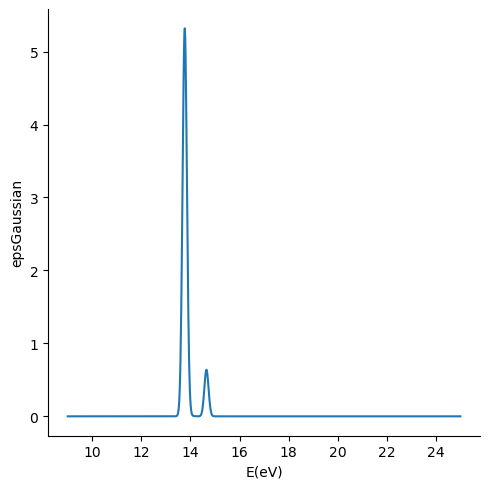

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
columns = ["E(eV)", "epsGaussian","IM(eps)Gaussian",  "epsLorentz",  "Im(esp)Lorentz"] 
df = pd.read_table("methane_spectrum.dat", comment="#", sep='\s+',names=columns) 
sns.relplot(x="E(eV)", y="epsGaussian", ci=None, kind="line", data=df) 
plt.plot()